# SPS MBB Dipole -- NCS Segment Full Harmonic Analysis

**Measurement session:** `20260206_142231_SPS_MBB`
**Segment:** NCS
**Magnet:** MBB (normal dipole, m=1)
**Kn calibration:** AC compensation (`Kn_values_Seg_Main_A_AC.txt`, cross-session from MBA)
**Drift correction:** Both **legacy** (C++ compatible) and **weighted** (Bottura/Pentella) modes

| Section | Content |
|---------|----------|
| 1 | Configuration & imports |
| 2 | Kn calibration (AC compensation) |
| 3 | Measurement data discovery |
| 4 | Raw signals: fluxes, current & voltage vs time |
| 5 | Pipeline processing -- legacy & weighted drift |
| 6 | Main field (B1) analysis |
| 7 | Transfer function B/I vs I |
| 8 | b2 (quadrupole) analysis |
| 9 | b3 (sextupole) analysis |
| 10 | Summary & export |

---
## 1. Configuration & Imports

In [1]:
# === CONFIGURATION ===
SEGMENT = "NCS"

SESSION = "2026_02_06_test/20260206_142231_SPS_MBB"
MEAS_SUBDIR = "20260206_142235_MBB"
# MBB session has no local Kn file; reuse MBA coil calibration (same coil)
KN_SUBPATH = None
KN_CROSS_SESSION = "20251212_171026_SPS_MBA/CRMMMMH_AV-00000001/Kn_values_Seg_Main_A_AC.txt"

MAGNET_ORDER = 1          # dipole
R_REF = 0.02              # reference radius [m]
L_COIL = 0.47             # coil length [m]
SAMPLES_PER_TURN = 1024   # encoder samples per revolution

# Pipeline options: drift + rotation + center-location + feeddown
OPTIONS = ("dri", "rot", "cel", "fed")

# Minimum |B1| for normalisation (avoid division by noise)
MIN_B1_T = 1e-4

kn_label = KN_SUBPATH.split('/')[-1] if KN_SUBPATH else KN_CROSS_SESSION.split('/')[-1]
print(f"SPS MBB Dipole -- {SEGMENT} Segment Full Analysis")
print("=" * 55)
print(f"  Segment       : {SEGMENT}")
print(f"  Session       : {SESSION}")
print(f"  Kn file       : {kn_label} {'(cross-session from MBA)' if KN_SUBPATH is None else ''}")
print(f"  Magnet order  : {MAGNET_ORDER} (dipole)")
print(f"  R_ref         : {R_REF} m")
print(f"  L_coil        : {L_COIL} m")
print(f"  Samples/turn  : {SAMPLES_PER_TURN}")
print(f"  Options       : {OPTIONS}")

SPS MBB Dipole -- NCS Segment Full Analysis
  Segment       : NCS
  Session       : 2026_02_06_test/20260206_142231_SPS_MBB
  Kn file       : Kn_values_Seg_Main_A_AC.txt (cross-session from MBA)
  Magnet order  : 1 (dipole)
  R_ref         : 0.02 m
  L_coil        : 0.47 m
  Samples/turn  : 1024
  Options       : ('dri', 'rot', 'cel', 'fed')


In [ ]:
import sys
from pathlib import Path
import re
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib widget
plt.rcParams.update({
    "figure.figsize": (12, 5),
    "axes.grid": True,
    "grid.alpha": 0.3,
    "figure.dpi": 100,
})

# Add repo root to path
repo_root = Path("../..").resolve()
if str(repo_root) not in sys.path:
    sys.path.insert(0, str(repo_root))

from rotating_coil_analyzer.analysis.kn_pipeline import (
    load_segment_kn_txt,
)
from rotating_coil_analyzer.analysis.utility_functions import (
    process_kn_pipeline,
    build_harmonic_rows,
)
from rotating_coil_analyzer.ingest.channel_detect import robust_range

print("Imports ready.")

In [3]:
# Repo root -- walk up from CWD until we find pyproject.toml or .git
REPO_ROOT = Path(".").resolve()
while REPO_ROOT != REPO_ROOT.parent:
    if (REPO_ROOT / "pyproject.toml").exists() or (REPO_ROOT / ".git").exists():
        break
    REPO_ROOT = REPO_ROOT.parent

SESSION_DIR = REPO_ROOT / "measurements" / SESSION
RUN_DIR = SESSION_DIR / MEAS_SUBDIR

# Kn calibration file (cross-session: same coil used for MBA & MBB)
if KN_SUBPATH is not None:
    KN_PATH = SESSION_DIR / KN_SUBPATH
else:
    KN_PATH = REPO_ROOT / "measurements" / KN_CROSS_SESSION

print(f"Repo root   : {REPO_ROOT}")
print(f"Session dir : {SESSION_DIR}")
print(f"Run dir     : {RUN_DIR}")
print(f"Kn file     : {KN_PATH}")
assert KN_PATH.exists(), f"Kn file not found: {KN_PATH}" 

Repo root   : C:\Users\albellel\python-projects\rotating-coil-analyzer
Session dir : C:\Users\albellel\python-projects\rotating-coil-analyzer\measurements\2026_02_06_test\20260206_142231_SPS_MBB
Run dir     : C:\Users\albellel\python-projects\rotating-coil-analyzer\measurements\2026_02_06_test\20260206_142231_SPS_MBB\20260206_142235_MBB
Kn file     : C:\Users\albellel\python-projects\rotating-coil-analyzer\measurements\20251212_171026_SPS_MBA\CRMMMMH_AV-00000001\Kn_values_Seg_Main_A_AC.txt


---
## 2. Kn Calibration (AC Compensation)

In [4]:
# Load Kn calibration
kn = load_segment_kn_txt(str(KN_PATH))
H = len(kn.orders)

print(f"Kn: {H} harmonics from {KN_PATH.name}")
print(f"  Orders: {list(kn.orders)}")

# Show absolute vs compensated sensitivity for main field
kn_abs_n1 = abs(kn.kn_abs[0])
kn_cmp_n1 = abs(kn.kn_cmp[0])
ratio_n1 = kn_abs_n1 / max(kn_cmp_n1, 1e-30)

print(f"\n  |Kn_abs(n=1)| = {kn_abs_n1:.6e}")
print(f"  |Kn_cmp(n=1)| = {kn_cmp_n1:.6e}")
print(f"  Abs/Cmp suppression ratio (n=1): {ratio_n1:.0f}x")

Kn: 15 harmonics from Kn_values_Seg_Main_A_AC.txt
  Orders: [np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9), np.int64(10), np.int64(11), np.int64(12), np.int64(13), np.int64(14), np.int64(15)]

  |Kn_abs(n=1)| = 1.154364e-01
  |Kn_cmp(n=1)| = 5.695530e-06
  Abs/Cmp suppression ratio (n=1): 20268x


---
## 3. Measurement Data Discovery

In [ ]:
FILE_PAT = re.compile(
    r"Run_(\d+)_I_([\d.]+)A_(N?CS)_raw_measurement_data\.txt$"
)

all_run_files = []
for f in sorted(RUN_DIR.iterdir()):
    m = FILE_PAT.search(f.name)
    if m:
        all_run_files.append((
            int(m.group(1)),     # run index
            float(m.group(2)),   # nominal current (A)
            m.group(3),          # segment: CS or NCS
            f,                   # full path
        ))

# Filter to NCS segment only
run_files = [r for r in all_run_files if r[2] == SEGMENT]

I_range = (min(r[1] for r in run_files), max(r[1] for r in run_files))

print(f"Found {len(all_run_files)} total raw files")
print(f"Filtered to {SEGMENT}: {len(run_files)} files")
print(f"  Current range: {I_range[0]:.0f} .. {I_range[1]:.0f} A")

# Determine channel assignment from the highest-current file available
run_files_sorted = sorted(run_files, key=lambda r: r[1], reverse=True)
sample_file = run_files_sorted[0][3]
sample_raw = np.loadtxt(sample_file)

r1 = robust_range(sample_raw[:, 1])
r2 = robust_range(sample_raw[:, 2])
SWAP_FLUX = (r2 > r1)
COL_ABS = 2 if SWAP_FLUX else 1
COL_CMP = 1 if SWAP_FLUX else 2

# Current column: pick by largest robust range among columns 3+
ncols = sample_raw.shape[1]
curr_ranges = [(robust_range(sample_raw[:, c]), c) for c in range(3, ncols)]
curr_ranges.sort(key=lambda x: -x[0])
COL_I = curr_ranges[0][1]

# Voltage / additional channel: the remaining column(s) after current
COL_V = None
if ncols > 4:
    other_cols = [c for _, c in curr_ranges if c != COL_I]
    if other_cols:
        COL_V = other_cols[0]

print(f"\nColumn assignment (from {sample_file.name}):")
print(f"  col 0         -> time (s)")
print(f"  col {COL_ABS}         -> flux abs (range={r1 if not SWAP_FLUX else r2:.4e})")
print(f"  col {COL_CMP}         -> flux cmp (range={r2 if not SWAP_FLUX else r1:.4e})")
print(f"  col {COL_I}         -> current  (range={curr_ranges[0][0]:.2f})")
if COL_V is not None:
    v_range = robust_range(sample_raw[:, COL_V])
    print(f"  col {COL_V}         -> voltage  (range={v_range:.4e})")
if SWAP_FLUX:
    print("  NOTE: flux columns swapped (col2 > col1 by robust range)")

print(f"\nRaw data shape: {sample_raw.shape} ({sample_raw.shape[0]//SAMPLES_PER_TURN} turns)")

---
## 4. Raw Signals: Fluxes, Current & Voltage vs Time

Visualise the acquired signals before any processing. This gives a
first sanity check on data quality, channel assignment, and signal levels.

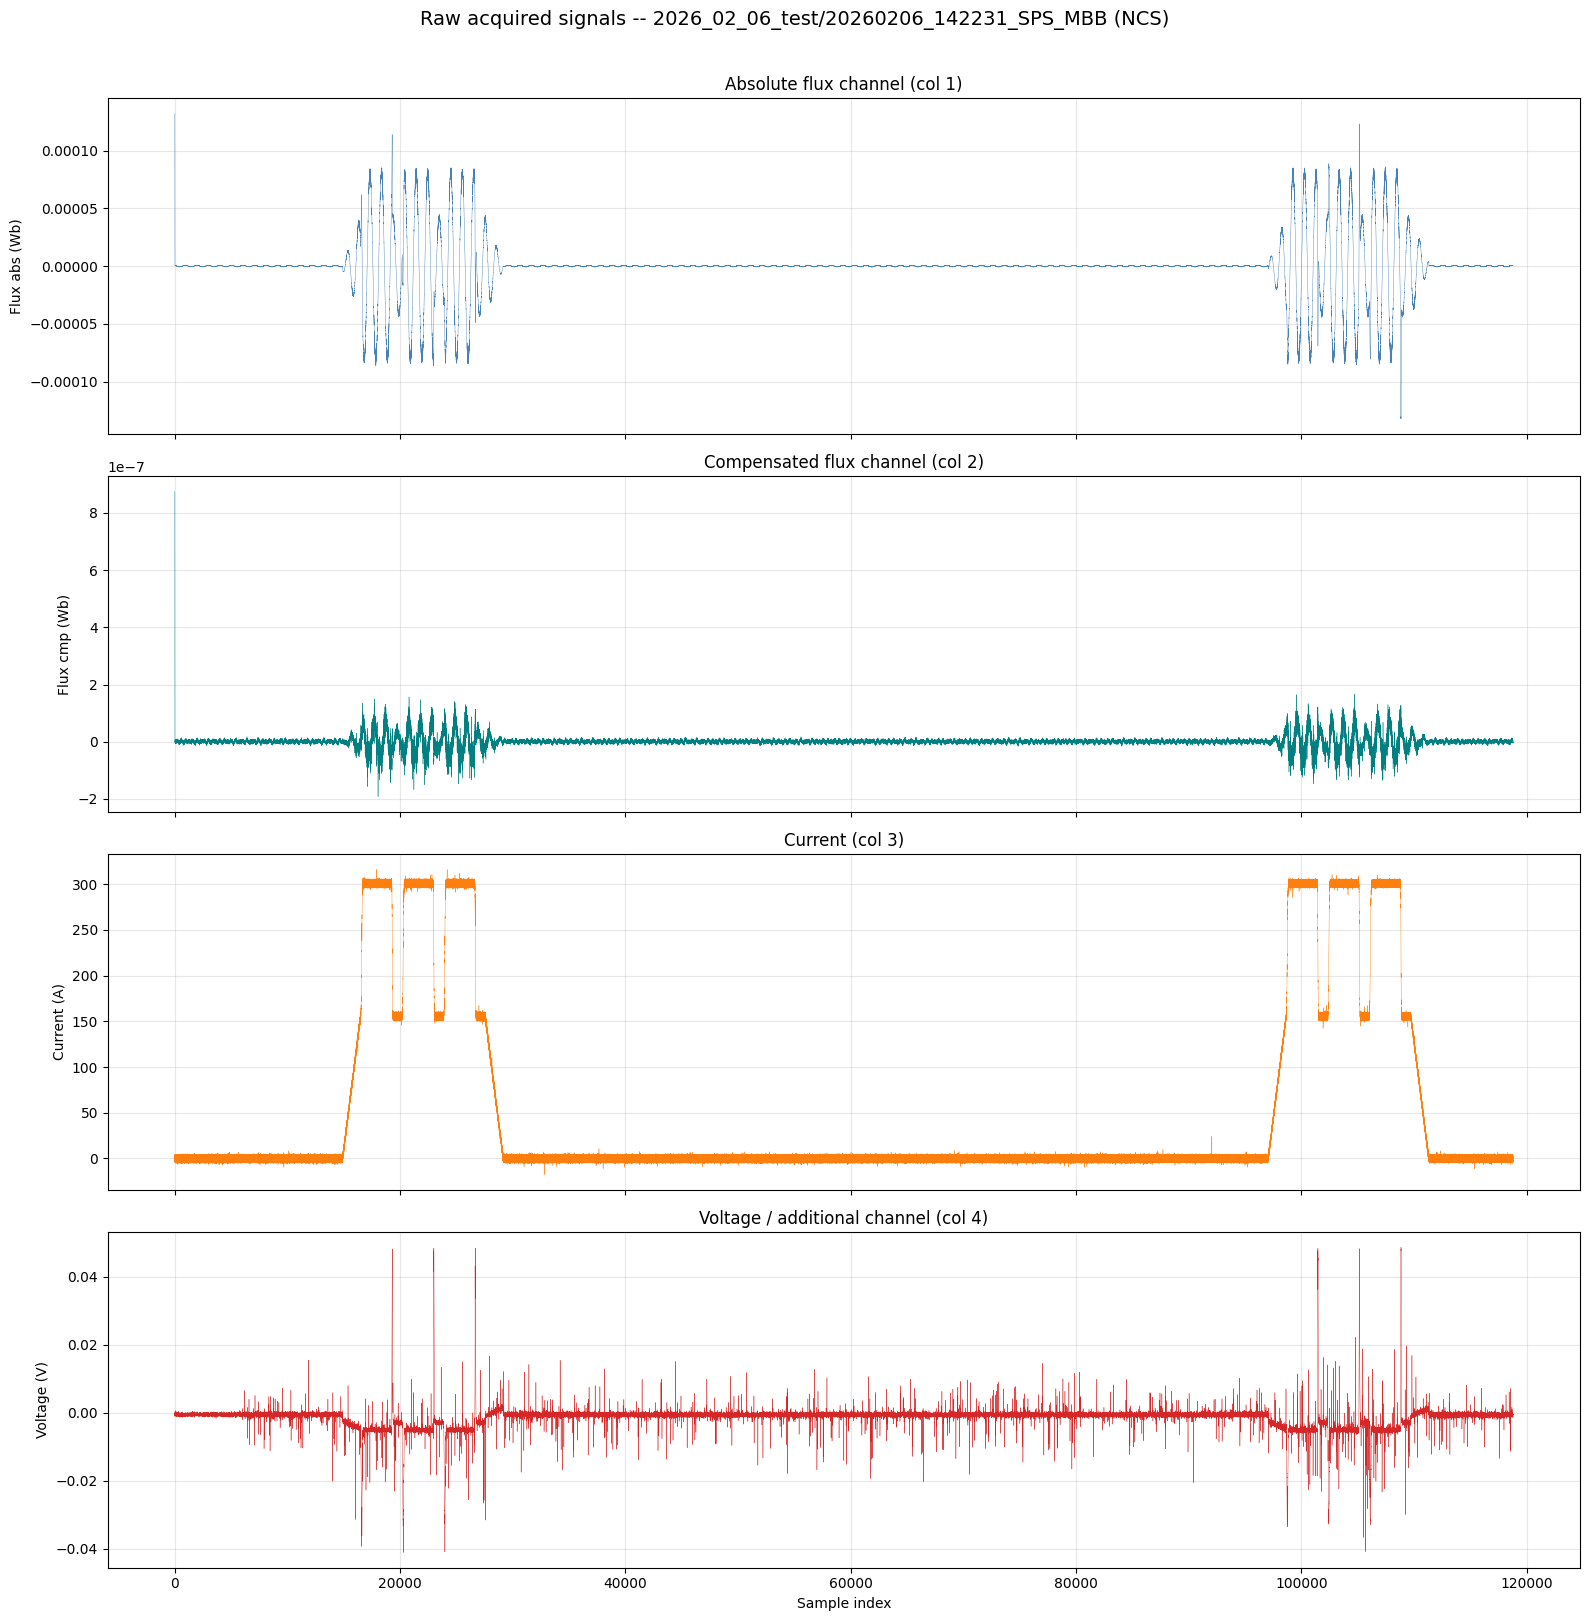


Raw signal summary (all NCS runs concatenated):
  Total samples : 118784
  flux_abs  : [-1.320773e-04, 1.319896e-04], mean=3.217805e-08, std=2.319119e-05
  flux_cmp  : [-1.921742e-07, 8.748356e-07], mean=5.469171e-10, std=2.065676e-08
  current   : [-1.758961e+01, 3.161134e+02], mean=5.310980e+01, std=1.058013e+02
  voltage   : [-4.115456e-02, 4.867440e-02], mean=-1.392664e-03, std=3.411527e-03


In [6]:
# Load all NCS raw data and concatenate for time-series view
raw_blocks = []
for run_idx, I_nom, seg, path in run_files:
    raw = np.loadtxt(path)
    block = {
        "run": run_idx, "I_nom": I_nom,
        "t": raw[:, 0],
        "flux_abs": raw[:, COL_ABS],
        "flux_cmp": raw[:, COL_CMP],
        "current": raw[:, COL_I],
    }
    if COL_V is not None:
        block["voltage"] = raw[:, COL_V]
    raw_blocks.append(block)

t_all = np.concatenate([b["t"] for b in raw_blocks])
flux_abs_all = np.concatenate([b["flux_abs"] for b in raw_blocks])
flux_cmp_all = np.concatenate([b["flux_cmp"] for b in raw_blocks])
current_all = np.concatenate([b["current"] for b in raw_blocks])
has_voltage = COL_V is not None
if has_voltage:
    voltage_all = np.concatenate([b["voltage"] for b in raw_blocks])

n_plots = 4 if has_voltage else 3
fig, axes = plt.subplots(n_plots, 1, figsize=(16, 4 * n_plots), sharex=True)

x = np.arange(len(t_all))

ax = axes[0]
ax.plot(x, flux_abs_all, linewidth=0.3, color="steelblue")
ax.set_ylabel("Flux abs (Wb)")
ax.set_title(f"Absolute flux channel (col {COL_ABS})")

ax = axes[1]
ax.plot(x, flux_cmp_all, linewidth=0.3, color="teal")
ax.set_ylabel("Flux cmp (Wb)")
ax.set_title(f"Compensated flux channel (col {COL_CMP})")

ax = axes[2]
ax.plot(x, current_all, linewidth=0.3, color="tab:orange")
ax.set_ylabel("Current (A)")
ax.set_title(f"Current (col {COL_I})")

if has_voltage:
    ax = axes[3]
    ax.plot(x, voltage_all, linewidth=0.3, color="tab:red")
    ax.set_ylabel("Voltage (V)")
    ax.set_title(f"Voltage / additional channel (col {COL_V})")

axes[-1].set_xlabel("Sample index")
fig.suptitle(f"Raw acquired signals -- {SESSION} ({SEGMENT})", fontsize=14, y=1.01)
plt.tight_layout()
plt.show()

# Per-signal summary
print("\nRaw signal summary (all NCS runs concatenated):")
print(f"  Total samples : {len(t_all)}")
for name, arr in [("flux_abs", flux_abs_all), ("flux_cmp", flux_cmp_all),
                   ("current", current_all)]:
    print(f"  {name:10s}: [{arr.min():.6e}, {arr.max():.6e}], "
          f"mean={arr.mean():.6e}, std={arr.std():.6e}")
if has_voltage:
    print(f"  {'voltage':10s}: [{voltage_all.min():.6e}, {voltage_all.max():.6e}], "
          f"mean={voltage_all.mean():.6e}, std={voltage_all.std():.6e}")

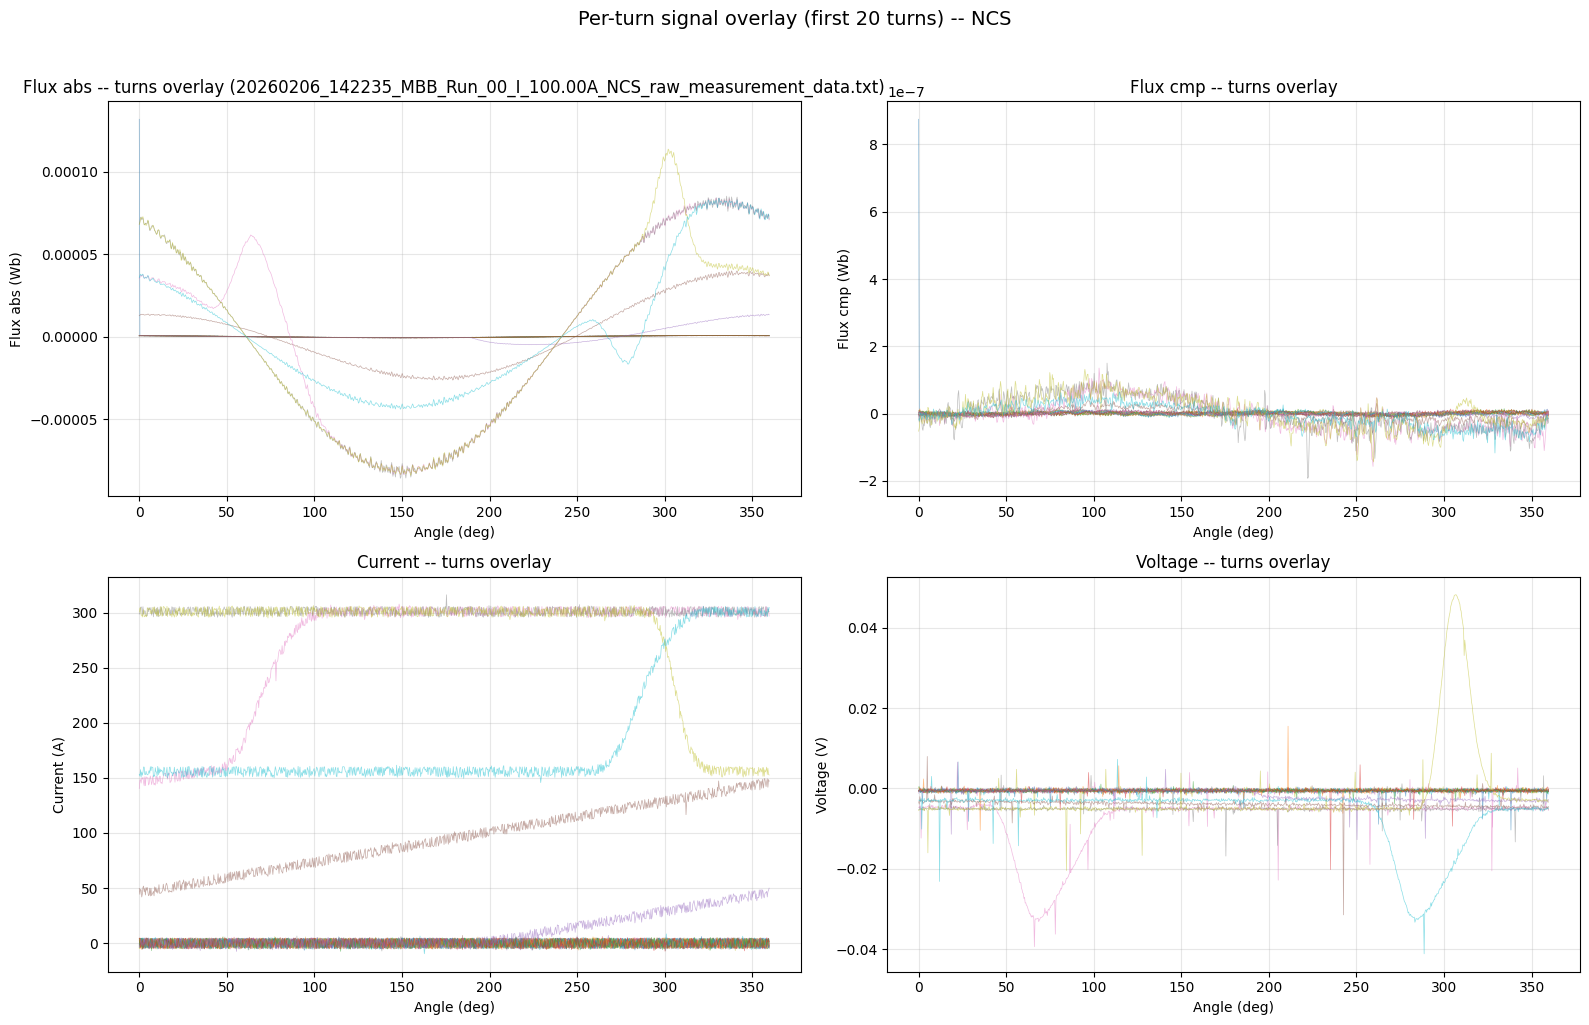

Showing 20 / 116 turns from 20260206_142235_MBB_Run_00_I_100.00A_NCS_raw_measurement_data.txt


In [7]:
# Per-turn view: overlay turns for one representative run
rep_path = run_files_sorted[0][3]  # highest-current run
rep_raw = np.loadtxt(rep_path)
Ns = SAMPLES_PER_TURN
n_turns_rep = rep_raw.shape[0] // Ns
n_show = min(n_turns_rep, 20)

angle = np.linspace(0, 360, Ns, endpoint=False)

fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# Flux abs per turn
ax = axes[0, 0]
for t in range(n_show):
    ax.plot(angle, rep_raw[t*Ns:(t+1)*Ns, COL_ABS], linewidth=0.5, alpha=0.5)
ax.set_xlabel("Angle (deg)")
ax.set_ylabel("Flux abs (Wb)")
ax.set_title(f"Flux abs -- turns overlay ({rep_path.name})")

# Flux cmp per turn
ax = axes[0, 1]
for t in range(n_show):
    ax.plot(angle, rep_raw[t*Ns:(t+1)*Ns, COL_CMP], linewidth=0.5, alpha=0.5)
ax.set_xlabel("Angle (deg)")
ax.set_ylabel("Flux cmp (Wb)")
ax.set_title("Flux cmp -- turns overlay")

# Current per turn
ax = axes[1, 0]
for t in range(n_show):
    ax.plot(angle, rep_raw[t*Ns:(t+1)*Ns, COL_I], linewidth=0.5, alpha=0.5)
ax.set_xlabel("Angle (deg)")
ax.set_ylabel("Current (A)")
ax.set_title("Current -- turns overlay")

# Voltage per turn
ax = axes[1, 1]
if has_voltage:
    for t in range(n_show):
        ax.plot(angle, rep_raw[t*Ns:(t+1)*Ns, COL_V], linewidth=0.5, alpha=0.5)
    ax.set_xlabel("Angle (deg)")
    ax.set_ylabel("Voltage (V)")
    ax.set_title("Voltage -- turns overlay")
else:
    ax.text(0.5, 0.5, "No voltage channel", transform=ax.transAxes,
            ha="center", va="center", fontsize=14, color="grey")

fig.suptitle(f"Per-turn signal overlay (first {n_show} turns) -- {SEGMENT}",
             fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

print(f"Showing {n_show} / {n_turns_rep} turns from {rep_path.name}")

---
## 5. Pipeline Processing -- Legacy & Weighted Drift

In [ ]:
Ns = SAMPLES_PER_TURN
m = MAGNET_ORDER
MAX_ZR = 0.01

def process_file(path, drift_mode):
    '''Process one raw file through the full kn pipeline.'''
    raw = np.loadtxt(path)
    n_total = raw.shape[0]
    n_turns = n_total // Ns
    if n_turns == 0:
        return []
    n_keep = n_turns * Ns
    shape = (n_turns, Ns)

    t_arr = raw[:n_keep, 0].reshape(shape)
    df_abs = raw[:n_keep, COL_ABS].reshape(shape)
    df_cmp = raw[:n_keep, COL_CMP].reshape(shape)
    I_arr = raw[:n_keep, COL_I].reshape(shape)

    result, C_merged, C_units, ok_main = process_kn_pipeline(
        flux_abs_turns=df_abs,
        flux_cmp_turns=df_cmp,
        t_turns=t_arr,
        I_turns=I_arr,
        kn=kn,
        r_ref=R_REF,
        magnet_order=m,
        options=OPTIONS,
        drift_mode=drift_mode,
        min_b1_T=MIN_B1_T,
        max_zr=MAX_ZR,
    )

    extra = [{"turn_in_run": t} for t in range(n_turns)]
    return build_harmonic_rows(result, C_merged, C_units, ok_main, m, extra)


# --- Main processing loop (NCS only) ---
rows_legacy = []
rows_weighted = []
n_failed = 0

for run_idx, I_nom, seg, path in run_files:
    for drift_mode, target in [("legacy", rows_legacy), ("weighted", rows_weighted)]:
        try:
            rows = process_file(path, drift_mode)
            for row in rows:
                row["run"] = run_idx
                row["segment"] = seg
                row["I_nom_A"] = I_nom
            target.extend(rows)
        except Exception as exc:
            if drift_mode == "legacy":
                n_failed += 1
                print(f"  SKIP {path.name}: {exc}")

df_L = pd.DataFrame(rows_legacy)
df_W = pd.DataFrame(rows_weighted)

for label, df in [("Legacy", df_L), ("Weighted", df_W)]:
    print(f"{label:>10s}: {len(df)} turns from "
          f"{df['run'].nunique()} runs ({SEGMENT} segment)")
if n_failed:
    print(f"  Failed: {n_failed} files")
print(f"\nHarmonics: n=1..{H}")
print(f"Current range: {df_L['I_mean_A'].min():.1f} .. {df_L['I_mean_A'].max():.1f} A")

n_ok = df_L["ok_main"].sum()
n_total_turns = len(df_L)
print(f"\nNormalization diagnostics:")
print(f"  Turns with |B1| > {MIN_B1_T} T (ok_main=True): {n_ok} / {n_total_turns}")
print(f"  Turns with weak B1 (ok_main=False): {n_total_turns - n_ok} / {n_total_turns}")

b1_vals = df_L["B1_T"].values
b1_finite = b1_vals[np.isfinite(b1_vals)]
if len(b1_finite) > 0:
    print(f"  B1 range: [{b1_finite.min():.6e}, {b1_finite.max():.6e}] T")

In [9]:
# --- Discover current levels and set up per-level masks ---
I_nom_all = df_L["I_nom_A"].values
I_rounded = np.round(I_nom_all).astype(int)

current_levels = sorted(set(I_rounded))
nonzero_levels = [lv for lv in current_levels if lv != 0]
nonzero_mask = I_rounded != 0

print(f"Current levels ({len(current_levels)}): {current_levels}")
print(f"Non-zero levels ({len(nonzero_levels)}): {nonzero_levels}")
print(f"0 A turns (excluded from normalised harmonics): {(~nonzero_mask).sum()}")
print(f"Non-zero turns: {nonzero_mask.sum()}")

Current levels (1): [np.int64(100)]
Non-zero levels (1): [np.int64(100)]
0 A turns (excluded from normalised harmonics): 0
Non-zero turns: 116


---
## 6. Main Field (B1) Analysis

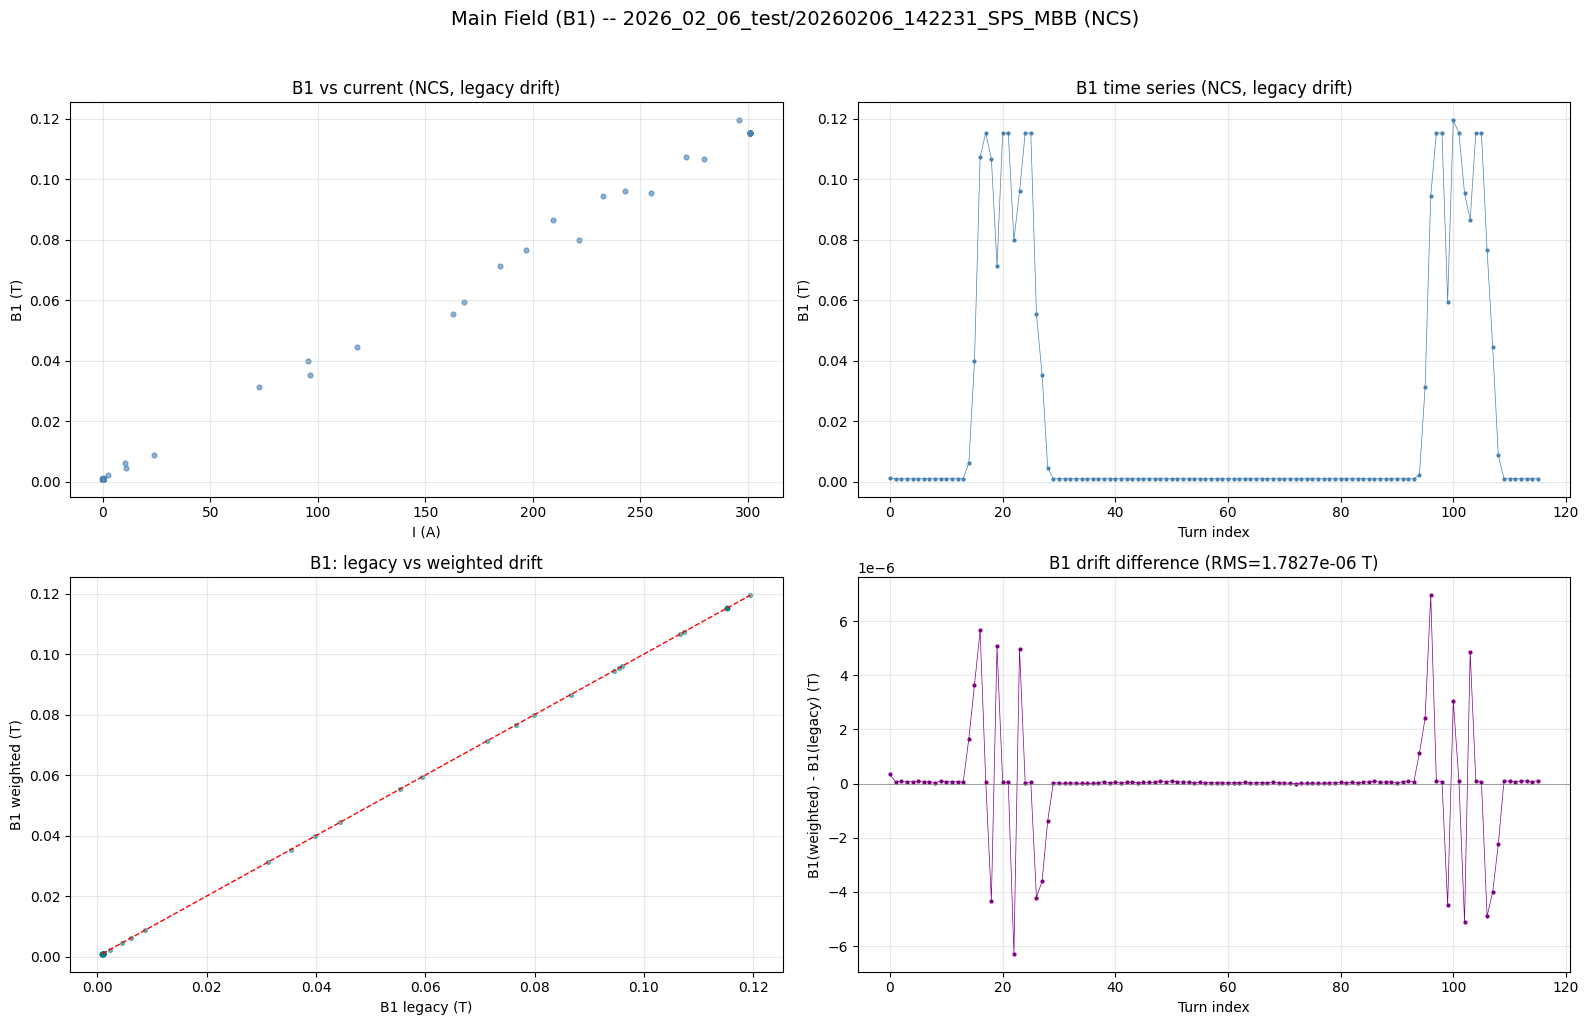


B1 per current level (legacy drift):
   I (A)    N     mean (T)      std (T)      min (T)      max (T)
-----------------------------------------------------------------
     100  116    +0.021149     0.039695    +0.000907    +0.119475


In [10]:
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# (a) B1 vs current (legacy)
ax = axes[0, 0]
ax.scatter(df_L["I_mean_A"], df_L["B1_T"],
           s=12, alpha=0.6, color="steelblue")
ax.set_xlabel("I (A)")
ax.set_ylabel("B1 (T)")
ax.set_title(f"B1 vs current ({SEGMENT}, legacy drift)")

# (b) B1 time series
ax = axes[0, 1]
ax.plot(df_L["B1_T"].values, ".-", markersize=4, linewidth=0.5, color="steelblue")
ax.set_xlabel("Turn index")
ax.set_ylabel("B1 (T)")
ax.set_title(f"B1 time series ({SEGMENT}, legacy drift)")

# (c) B1 legacy vs weighted
ax = axes[1, 0]
ax.scatter(df_L["B1_T"], df_W["B1_T"], s=8, alpha=0.5, c="teal")
lims = [min(df_L["B1_T"].min(), df_W["B1_T"].min()),
        max(df_L["B1_T"].max(), df_W["B1_T"].max())]
ax.plot(lims, lims, "r--", linewidth=1)
ax.set_xlabel("B1 legacy (T)")
ax.set_ylabel("B1 weighted (T)")
ax.set_title("B1: legacy vs weighted drift")

# (d) B1 difference
ax = axes[1, 1]
b1_diff = df_W["B1_T"].values - df_L["B1_T"].values
ax.plot(b1_diff, ".-", markersize=4, linewidth=0.5, color="purple")
ax.axhline(0, color="grey", linewidth=0.5)
ax.set_xlabel("Turn index")
ax.set_ylabel("B1(weighted) - B1(legacy) (T)")
ax.set_title(f"B1 drift difference (RMS={np.sqrt(np.mean(b1_diff**2)):.4e} T)")

fig.suptitle(f"Main Field (B1) -- {SESSION} ({SEGMENT})", fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

# B1 per-level summary
print("\nB1 per current level (legacy drift):")
print(f"{'I (A)':>8s} {'N':>4s} {'mean (T)':>12s} {'std (T)':>12s} "
      f"{'min (T)':>12s} {'max (T)':>12s}")
print("-" * 65)
for lv in current_levels:
    mask = I_rounded == lv
    vals = df_L.loc[mask, "B1_T"].values
    ok = np.isfinite(vals)
    if ok.sum() == 0:
        continue
    v = vals[ok]
    print(f"{lv:8d} {ok.sum():4d} {v.mean():+12.6f} {v.std():12.6f} "
          f"{v.min():+12.6f} {v.max():+12.6f}")

---
## 7. Transfer Function B/I vs I

The transfer function TF = B1 / I characterises how efficiently the magnet
converts current to field.  For a linear (unsaturated) magnet TF is constant;
saturation shows as a drop at high current.

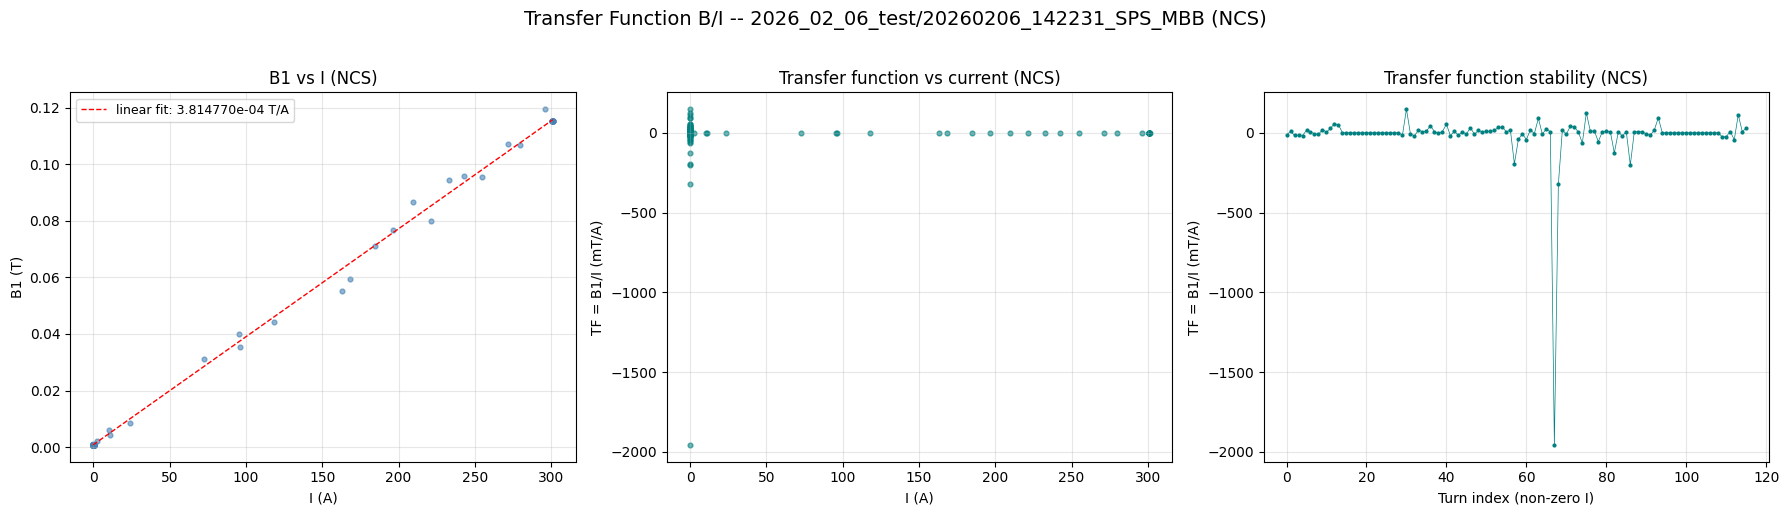


Transfer function per current level:
   I (A)    N   TF mean (mT/A)    TF std (mT/A)
--------------------------------------------------
     100  116       -16.577527       188.060178

Overall TF (I != 0): -16.577527 +/- 188.060178 mT/A


In [11]:
# Transfer function: B1/I for non-zero current turns
ok_tf = nonzero_mask & np.isfinite(df_L["B1_T"].values)
I_tf = df_L.loc[ok_tf, "I_mean_A"].values
B1_tf = df_L.loc[ok_tf, "B1_T"].values
TF = B1_tf / I_tf  # T/A

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# (a) B1 vs I (linearity check)
ax = axes[0]
ax.scatter(I_tf, B1_tf, s=12, alpha=0.6, color="steelblue")
if len(I_tf) > 1:
    coeffs = np.polyfit(I_tf, B1_tf, 1)
    I_fit = np.linspace(I_tf.min(), I_tf.max(), 100)
    ax.plot(I_fit, np.polyval(coeffs, I_fit), "r--", linewidth=1,
            label=f"linear fit: {coeffs[0]:.6e} T/A")
    ax.legend(fontsize=9)
ax.set_xlabel("I (A)")
ax.set_ylabel("B1 (T)")
ax.set_title(f"B1 vs I ({SEGMENT})")

# (b) TF = B1/I vs I
ax = axes[1]
ax.scatter(I_tf, TF * 1e3, s=12, alpha=0.6, color="teal")
ax.set_xlabel("I (A)")
ax.set_ylabel("TF = B1/I (mT/A)")
ax.set_title(f"Transfer function vs current ({SEGMENT})")

# (c) TF vs turn index (stability)
ax = axes[2]
ax.plot(TF * 1e3, ".-", markersize=4, linewidth=0.5, color="teal")
ax.set_xlabel("Turn index (non-zero I)")
ax.set_ylabel("TF = B1/I (mT/A)")
ax.set_title(f"Transfer function stability ({SEGMENT})")

fig.suptitle(f"Transfer Function B/I -- {SESSION} ({SEGMENT})", fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

# TF per-level summary
print("\nTransfer function per current level:")
print(f"{'I (A)':>8s} {'N':>4s} {'TF mean (mT/A)':>16s} {'TF std (mT/A)':>16s}")
print("-" * 50)
for lv in nonzero_levels:
    mask = (I_rounded == lv) & np.isfinite(df_L["B1_T"].values)
    I_v = df_L.loc[mask, "I_mean_A"].values
    B1_v = df_L.loc[mask, "B1_T"].values
    tf_v = B1_v / I_v * 1e3
    ok = np.isfinite(tf_v)
    if ok.sum() == 0:
        continue
    tf_ok = tf_v[ok]
    print(f"{lv:8d} {ok.sum():4d} {tf_ok.mean():16.6f} {tf_ok.std():16.6f}")

print(f"\nOverall TF (I != 0): {np.nanmean(TF)*1e3:.6f} +/- {np.nanstd(TF)*1e3:.6f} mT/A")

---
## 8. b2 (Quadrupole) Analysis

b2 is the first allowed harmonic error for a dipole.  In a perfect
dipole b2 = 0.  Non-zero values indicate quadrupole feed-down from
off-centre coil position or genuine magnet error.

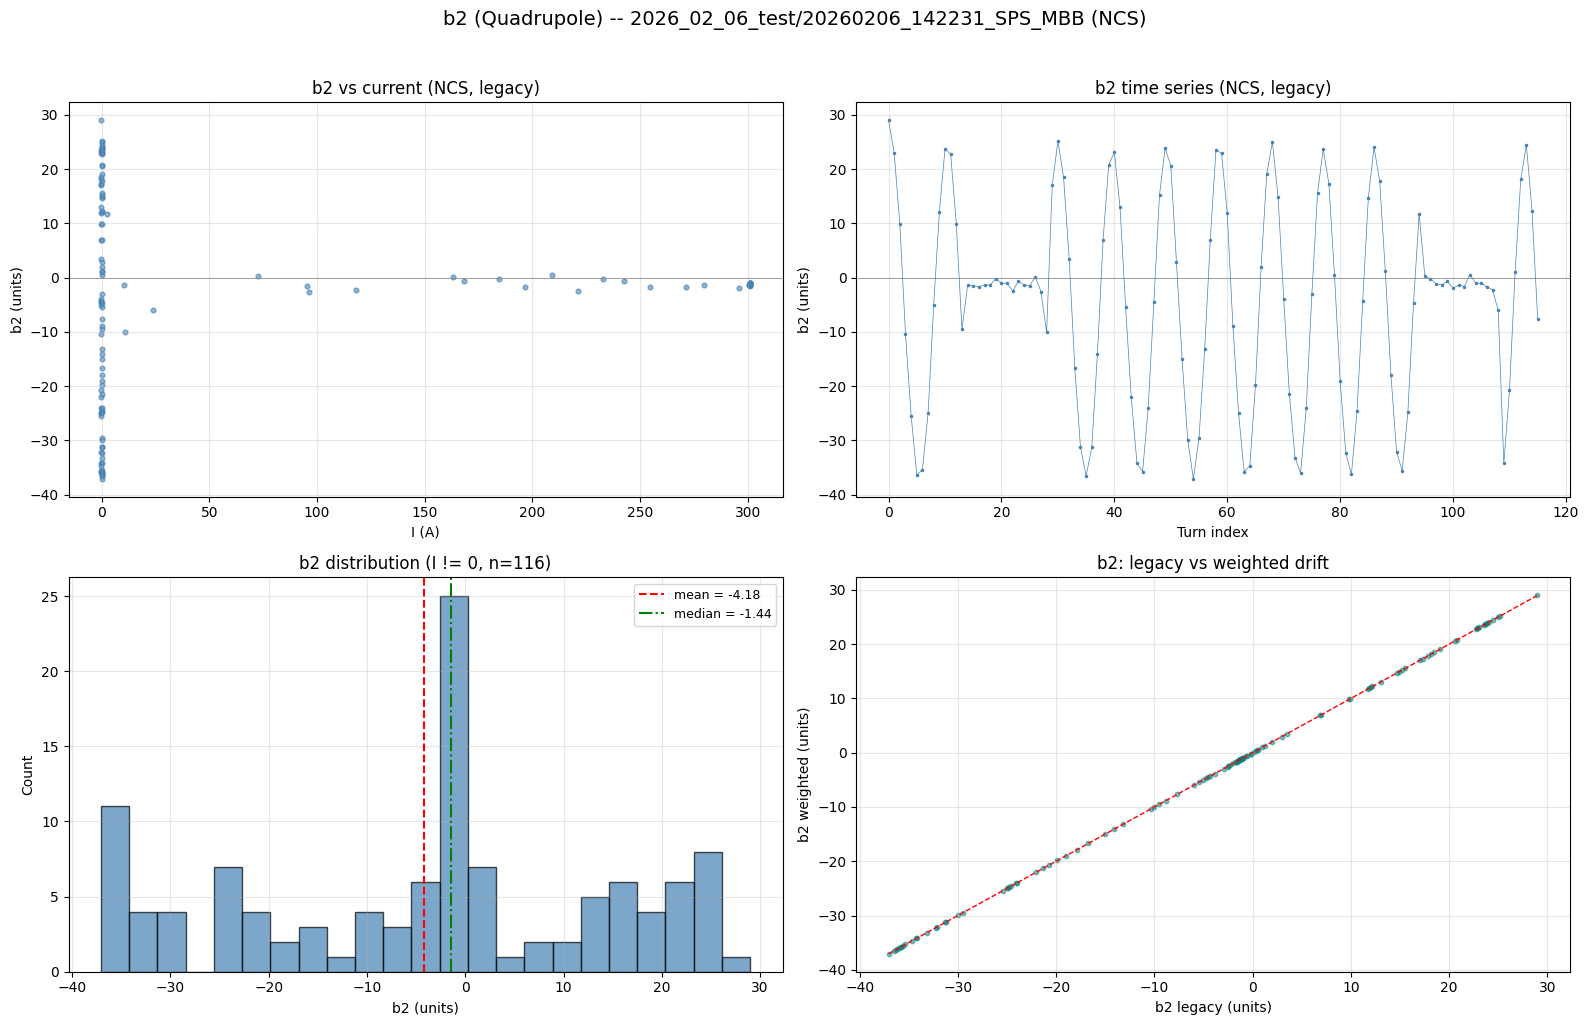


b2 per current level (NCS, legacy, 0 A excluded):
   I (A)    N       mean        std     median
---------------------------------------------
     100  116    -4.1839    18.7456    -1.4416


In [12]:
b2_L = df_L["b2_units"].values
b2_W = df_W["b2_units"].values

fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# (a) b2 vs current
ax = axes[0, 0]
nz_ok = nonzero_mask & np.isfinite(b2_L)
ax.scatter(df_L.loc[nz_ok, "I_mean_A"], b2_L[nz_ok],
           s=12, alpha=0.6, color="steelblue", label=SEGMENT)
ax.axhline(0, color="grey", linewidth=0.5)
ax.set_xlabel("I (A)")
ax.set_ylabel("b2 (units)")
ax.set_title(f"b2 vs current ({SEGMENT}, legacy)")

# (b) b2 time series
ax = axes[0, 1]
ax.plot(b2_L, ".-", markersize=3, linewidth=0.5, color="steelblue")
ax.axhline(0, color="grey", linewidth=0.5)
ax.set_xlabel("Turn index")
ax.set_ylabel("b2 (units)")
ax.set_title(f"b2 time series ({SEGMENT}, legacy)")

# (c) b2 histogram (non-zero current)
ax = axes[1, 0]
b2_nz = b2_L[nz_ok]
if len(b2_nz) > 0:
    ax.hist(b2_nz, bins=max(10, len(b2_nz) // 5), edgecolor="black",
            alpha=0.7, color="steelblue")
    ax.axvline(np.nanmean(b2_nz), color="r", linestyle="--",
               label=f"mean = {np.nanmean(b2_nz):.2f}")
    ax.axvline(np.nanmedian(b2_nz), color="g", linestyle="-.",
               label=f"median = {np.nanmedian(b2_nz):.2f}")
    ax.legend(fontsize=9)
ax.set_xlabel("b2 (units)")
ax.set_ylabel("Count")
ax.set_title(f"b2 distribution (I != 0, n={nz_ok.sum()})")

# (d) b2 legacy vs weighted
ax = axes[1, 1]
ok2 = np.isfinite(b2_L) & np.isfinite(b2_W) & nonzero_mask
if ok2.sum() > 0:
    ax.scatter(b2_L[ok2], b2_W[ok2], s=10, alpha=0.5, c="teal")
    lims2 = [min(np.nanmin(b2_L[ok2]), np.nanmin(b2_W[ok2])),
             max(np.nanmax(b2_L[ok2]), np.nanmax(b2_W[ok2]))]
    ax.plot(lims2, lims2, "r--", linewidth=1)
ax.set_xlabel("b2 legacy (units)")
ax.set_ylabel("b2 weighted (units)")
ax.set_title("b2: legacy vs weighted drift")

fig.suptitle(f"b2 (Quadrupole) -- {SESSION} ({SEGMENT})", fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

# b2 per-level summary
print(f"\nb2 per current level ({SEGMENT}, legacy, 0 A excluded):")
print(f"{'I (A)':>8s} {'N':>4s} {'mean':>10s} {'std':>10s} {'median':>10s}")
print("-" * 45)
for lv in nonzero_levels:
    mask = (I_rounded == lv) & np.isfinite(b2_L)
    vals = b2_L[mask]
    if len(vals) == 0:
        continue
    print(f"{lv:8d} {len(vals):4d} {np.mean(vals):+10.4f} "
          f"{np.std(vals):10.4f} {np.median(vals):+10.4f}")

---
## 9. b3 (Sextupole) Analysis

b3 is the first non-allowed harmonic for an ideal dipole and a key quality
indicator for accelerator operation.

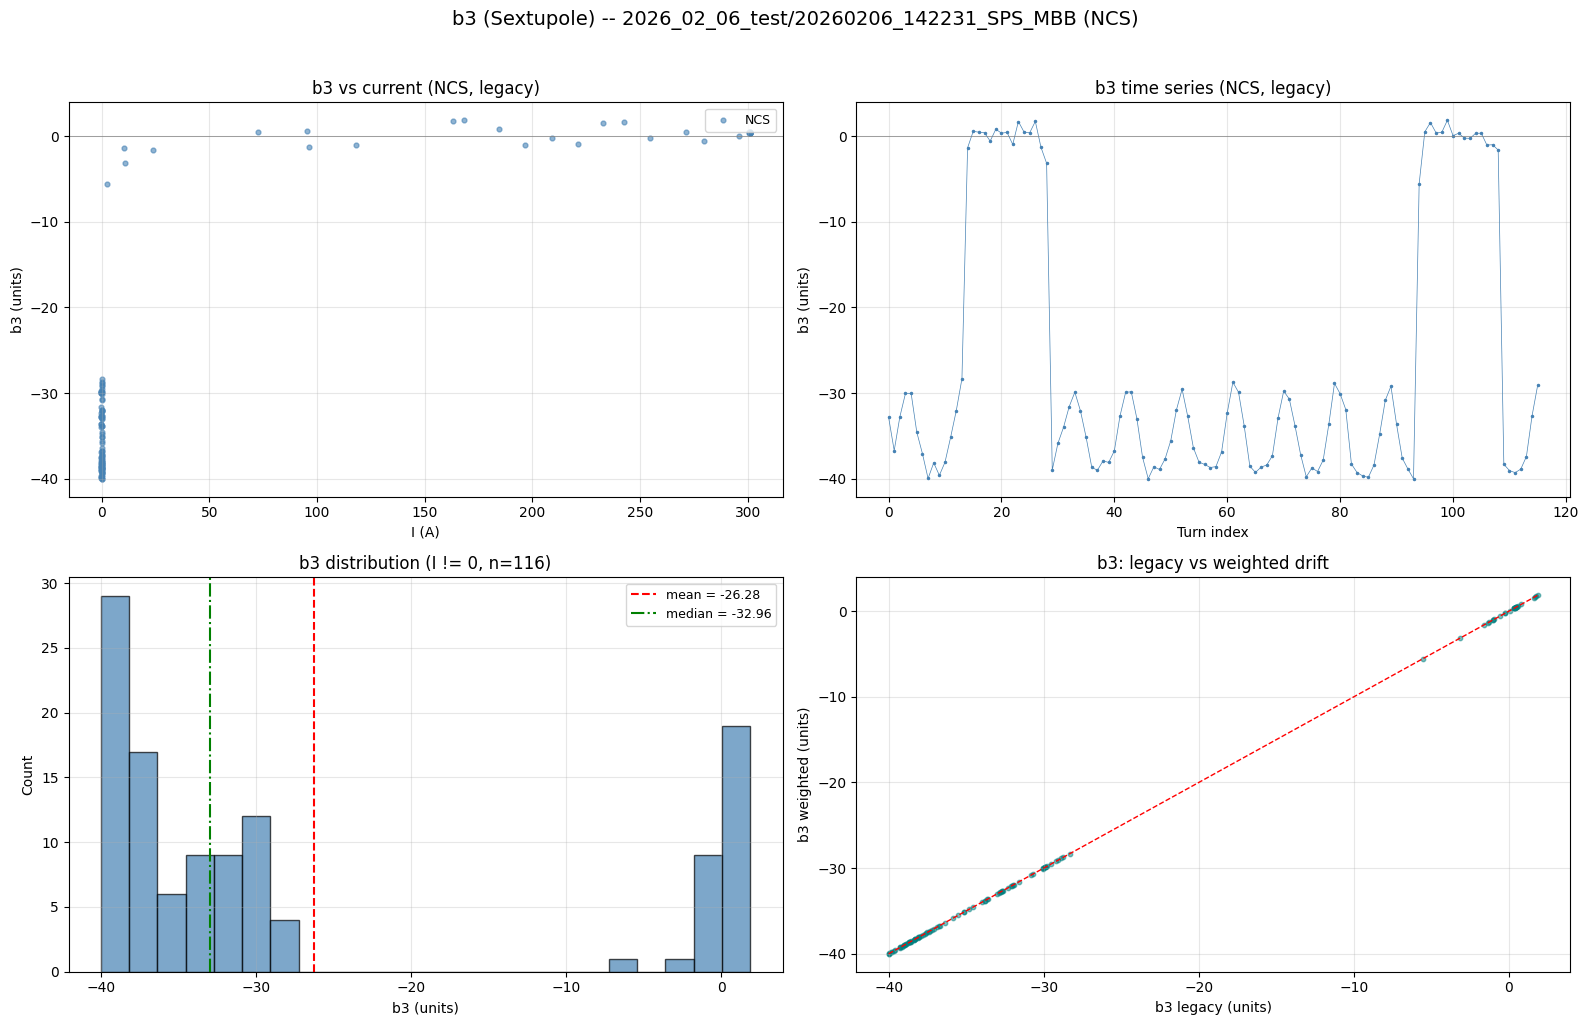


b3 per current level (NCS, legacy, 0 A excluded):
   I (A)    N       mean        std     median
---------------------------------------------
     100  116   -26.2827    15.7793   -32.9637


In [13]:
b3_L = df_L["b3_units"].values
b3_W = df_W["b3_units"].values

fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# (a) b3 vs current
ax = axes[0, 0]
nz_b3 = nonzero_mask & np.isfinite(b3_L)
zero_b3 = (~nonzero_mask) & np.isfinite(b3_L)
ax.scatter(df_L.loc[nz_b3, "I_mean_A"], b3_L[nz_b3],
           s=12, alpha=0.6, color="steelblue", label=SEGMENT)
if zero_b3.sum() > 0:
    ax.scatter(df_L.loc[zero_b3, "I_mean_A"], b3_L[zero_b3],
               c="lightgrey", s=8, edgecolors="grey", linewidths=0.3,
               alpha=0.5, label="0 A (noise)", zorder=0)
ax.axhline(0, color="grey", linewidth=0.5)
ax.set_xlabel("I (A)")
ax.set_ylabel("b3 (units)")
ax.set_title(f"b3 vs current ({SEGMENT}, legacy)")
ax.legend(fontsize=9)

# (b) b3 time series
ax = axes[0, 1]
ax.plot(b3_L, ".-", markersize=3, linewidth=0.5, color="steelblue")
ax.axhline(0, color="grey", linewidth=0.5)
ax.set_xlabel("Turn index")
ax.set_ylabel("b3 (units)")
ax.set_title(f"b3 time series ({SEGMENT}, legacy)")

# (c) b3 histogram (non-zero current)
ax = axes[1, 0]
b3_nz = b3_L[nz_b3]
if len(b3_nz) > 0:
    ax.hist(b3_nz, bins=max(10, len(b3_nz) // 5), edgecolor="black",
            alpha=0.7, color="steelblue")
    ax.axvline(np.nanmean(b3_nz), color="r", linestyle="--",
               label=f"mean = {np.nanmean(b3_nz):.2f}")
    ax.axvline(np.nanmedian(b3_nz), color="g", linestyle="-.",
               label=f"median = {np.nanmedian(b3_nz):.2f}")
    ax.legend(fontsize=9)
ax.set_xlabel("b3 (units)")
ax.set_ylabel("Count")
ax.set_title(f"b3 distribution (I != 0, n={nz_b3.sum()})")

# (d) b3 legacy vs weighted
ax = axes[1, 1]
ok3 = np.isfinite(b3_L) & np.isfinite(b3_W) & nonzero_mask
if ok3.sum() > 0:
    ax.scatter(b3_L[ok3], b3_W[ok3], s=10, alpha=0.5, c="teal")
    lims3 = [min(np.nanmin(b3_L[ok3]), np.nanmin(b3_W[ok3])),
             max(np.nanmax(b3_L[ok3]), np.nanmax(b3_W[ok3]))]
    ax.plot(lims3, lims3, "r--", linewidth=1)
ax.set_xlabel("b3 legacy (units)")
ax.set_ylabel("b3 weighted (units)")
ax.set_title("b3: legacy vs weighted drift")

fig.suptitle(f"b3 (Sextupole) -- {SESSION} ({SEGMENT})", fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

# b3 per-level summary
print(f"\nb3 per current level ({SEGMENT}, legacy, 0 A excluded):")
print(f"{'I (A)':>8s} {'N':>4s} {'mean':>10s} {'std':>10s} {'median':>10s}")
print("-" * 45)
for lv in nonzero_levels:
    mask = (I_rounded == lv) & np.isfinite(b3_L)
    vals = b3_L[mask]
    if len(vals) == 0:
        continue
    print(f"{lv:8d} {len(vals):4d} {np.mean(vals):+10.4f} "
          f"{np.std(vals):10.4f} {np.median(vals):+10.4f}")

---
## 10. Summary & Export

In [14]:
print("=" * 70)
print(f"SPS MBB DIPOLE -- {SEGMENT} SEGMENT FULL ANALYSIS SUMMARY")
print("=" * 70)

print(f"\nSegment         : {SEGMENT}")
print(f"Measurement     : {SESSION}")
print(f"Kn calibration  : {KN_PATH.name} (AC compensation, cross-session)")
print(f"Magnet          : MBB dipole (m={MAGNET_ORDER})")
print(f"R_ref           : {R_REF} m")
print(f"Samples/turn    : {SAMPLES_PER_TURN}")
print(f"Pipeline options: {OPTIONS}")

print(f"\n--- Data Summary ---")
print(f"Total files     : {len(run_files)} ({SEGMENT} only)")
print(f"Total turns     : {len(df_L)}")
print(f"Current levels  : {len(current_levels)} ({len(nonzero_levels)} non-zero)")
print(f"Current range   : {I_range[0]:.0f} .. {I_range[1]:.0f} A")

# B1
print(f"\n--- Main Field (B1) ---")
b1_nz = df_L.loc[nonzero_mask, "B1_T"].values
b1_ok = b1_nz[np.isfinite(b1_nz)]
if len(b1_ok) > 0:
    print(f"B1 range (I!=0) : [{b1_ok.min():.6f}, {b1_ok.max():.6f}] T")
    print(f"B1 mean  (I!=0) : {b1_ok.mean():.6f} T")

# Transfer function
print(f"\n--- Transfer Function ---")
I_nz_vals = df_L.loc[nonzero_mask, "I_mean_A"].values
tf_nz = b1_nz / I_nz_vals
tf_ok = tf_nz[np.isfinite(tf_nz)]
if len(tf_ok) > 0:
    print(f"TF mean (I!=0)  : {tf_ok.mean()*1e3:.6f} mT/A")
    print(f"TF std  (I!=0)  : {tf_ok.std()*1e3:.6f} mT/A")

# b2
print(f"\n--- b2 (Quadrupole) ---")
b2_nz_vals = b2_L[nonzero_mask & np.isfinite(b2_L)]
if len(b2_nz_vals) > 0:
    print(f"b2 mean  (I!=0) : {np.mean(b2_nz_vals):+.4f} units")
    print(f"b2 std   (I!=0) : {np.std(b2_nz_vals):.4f} units")

# b3
print(f"\n--- b3 (Sextupole) ---")
b3_nz_vals = b3_L[nonzero_mask & np.isfinite(b3_L)]
if len(b3_nz_vals) > 0:
    print(f"b3 mean  (I!=0) : {np.mean(b3_nz_vals):+.4f} units")
    print(f"b3 std   (I!=0) : {np.std(b3_nz_vals):.4f} units")

# Drift comparison
print(f"\n--- Drift Correction (legacy vs weighted, I!=0) ---")
for name, col in [("B1", "B1_T"), ("b2", "b2_units"), ("b3", "b3_units")]:
    vL = df_L.loc[nonzero_mask, col].values if col in df_L.columns else np.array([])
    vW = df_W.loc[nonzero_mask, col].values if col in df_W.columns else np.array([])
    ok = np.isfinite(vL) & np.isfinite(vW)
    if ok.sum() > 0:
        d = vW[ok] - vL[ok]
        unit = "T" if "T" in col else "units"
        print(f"  {name:3s} RMS diff: {np.sqrt(np.mean(d**2)):.6e} {unit}")

SPS MBB DIPOLE -- NCS SEGMENT FULL ANALYSIS SUMMARY

Segment         : NCS
Measurement     : 2026_02_06_test/20260206_142231_SPS_MBB
Kn calibration  : Kn_values_Seg_Main_A_AC.txt (AC compensation, cross-session)
Magnet          : MBB dipole (m=1)
R_ref           : 0.02 m
Samples/turn    : 1024
Pipeline options: ('dri', 'rot', 'cel', 'fed')

--- Data Summary ---
Total files     : 1 (NCS only)
Total turns     : 116
Current levels  : 1 (1 non-zero)
Current range   : 100 .. 100 A

--- Main Field (B1) ---
B1 range (I!=0) : [0.000907, 0.119475] T
B1 mean  (I!=0) : 0.021149 T

--- Transfer Function ---
TF mean (I!=0)  : -16.577527 mT/A
TF std  (I!=0)  : 188.060178 mT/A

--- b2 (Quadrupole) ---
b2 mean  (I!=0) : -4.1839 units
b2 std   (I!=0) : 18.7456 units

--- b3 (Sextupole) ---
b3 mean  (I!=0) : -26.2827 units
b3 std   (I!=0) : 15.7793 units

--- Drift Correction (legacy vs weighted, I!=0) ---
  B1  RMS diff: 1.782742e-06 T
  b2  RMS diff: 1.355266e-02 units
  b3  RMS diff: 5.961734e-03 uni

In [15]:
# Export computed results
out_dir = REPO_ROOT / "output" / SESSION
out_dir.mkdir(parents=True, exist_ok=True)

for label, df_out in [("legacy", df_L), ("weighted", df_W)]:
    fname = f"MBB_{SEGMENT}_computed_{label}_drift.csv"
    df_out.to_csv(out_dir / fname, index=False)
    print(f"Wrote {out_dir / fname}  ({len(df_out)} rows)")

print("\nDone.")

Wrote C:\Users\albellel\python-projects\rotating-coil-analyzer\output\2026_02_06_test\20260206_142231_SPS_MBB\MBB_NCS_computed_legacy_drift.csv  (116 rows)
Wrote C:\Users\albellel\python-projects\rotating-coil-analyzer\output\2026_02_06_test\20260206_142231_SPS_MBB\MBB_NCS_computed_weighted_drift.csv  (116 rows)

Done.
